In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from PIL import Image

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers  import Dense, Dropout, Flatten, Conv2D,MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.python.keras import utils
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

np.random.seed(42)

%matplotlib inline

In [2]:
ls ../input/chest_xray/chest_xray/train/NORMAL/* | head

../input/chest_xray/chest_xray/train/NORMAL/IM-0115-0001.jpeg
../input/chest_xray/chest_xray/train/NORMAL/IM-0117-0001.jpeg
../input/chest_xray/chest_xray/train/NORMAL/IM-0119-0001.jpeg
../input/chest_xray/chest_xray/train/NORMAL/IM-0122-0001.jpeg
../input/chest_xray/chest_xray/train/NORMAL/IM-0125-0001.jpeg
../input/chest_xray/chest_xray/train/NORMAL/IM-0127-0001.jpeg
../input/chest_xray/chest_xray/train/NORMAL/IM-0128-0001.jpeg
../input/chest_xray/chest_xray/train/NORMAL/IM-0129-0001.jpeg
../input/chest_xray/chest_xray/train/NORMAL/IM-0131-0001.jpeg
../input/chest_xray/chest_xray/train/NORMAL/IM-0133-0001.jpeg


Normal
Size of image:(1468, 993)


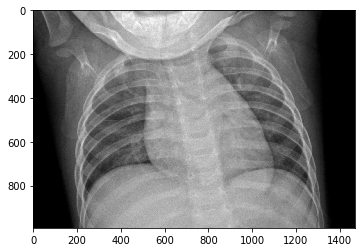

(1468, 993)

In [3]:
image_ex = load_img("../input/chest_xray/chest_xray/train/NORMAL/IM-0133-0001.jpeg")

print("Normal")
print(f"Size of image:{image_ex.size}")
plt.imshow(image_ex)
plt.show()
image_ex.size

# will need to do shear

In [4]:
ls ../input/chest_xray/chest_xray/train/PNEUMONIA/* | head

/bin/sh: /bin/ls: Argument list too long


Pneumonia
Size of image:(1244, 863)


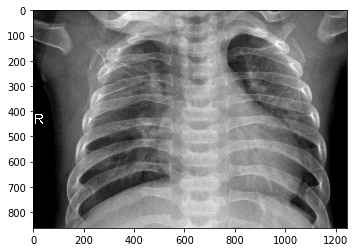

In [5]:
image_ex = load_img("../input/chest_xray/chest_xray/train/PNEUMONIA/person1001_bacteria_2932.jpeg")

print("Pneumonia")
print(f"Size of image:{image_ex.size}")
plt.imshow(image_ex)
plt.show()

In [6]:
image_ex.size

(1244, 863)

In [7]:
# directory paths
train_dir = "../input/chest_xray/chest_xray/train"
val_dir = "../input/chest_xray/chest_xray/val"
test_dir = "../input/chest_xray/chest_xray/test"

In [44]:
# basic CNN model

model = Sequential()

# Convolutional layer
model.add(Conv2D(filters = 16, #number of filters
                 kernel_size = (3,3), # height/width of the filter
                 activation = "relu", # activation function
                 input_shape = (224,224,3) )) # shape of input(image)

# Pooling layer
model.add(MaxPooling2D(pool_size = (2,2))) # height/width of pooling

# Another Convolutional layer
model.add(Conv2D(filters = 64,
                 kernel_size = (3,3),
                 activation = "relu"))

model.add(MaxPooling2D(pool_size =(2,2)))

# Flattening layer
model.add(Flatten())

# Dense layer
model.add(Dense(64, 
                activation = "relu"))

# Dropout layer
model.add(Dropout(0.5))

model.add(Dense(32,
                activation = "relu"))

model.add(Dropout(0.5))

# Output layer
model.add(Dense(2,
                activation = "softmax"))

In [45]:
# check
model.input, model.output

(<tf.Tensor 'conv2d_10_input:0' shape=(None, 224, 224, 3) dtype=float32>,
 <tf.Tensor 'dense_17/Identity:0' shape=(None, 2) dtype=float32>)

In [46]:
# Early Stopping
early_stop = EarlyStopping(monitor = "val_loss",
                           min_delta = 0,
                           patience = 3)

# Compile model
model.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])


In [47]:
# Input shape
model.input_shape[1:3]

(224, 224)

In [48]:
# Data Generator 

#Defining image augmentation
train_idg = ImageDataGenerator(rescale = 1./255,
                               zoom_range = 0.2,
                               shear_range = 0.2,
                               rotation_range = 20,
                               horizontal_flip = True)

test_idg = ImageDataGenerator(rescale = 1./255)

#Creating data loaders
train_gen = train_idg.flow_from_directory(train_dir,
                                    model.input_shape[1:3],
                                    color_mode = "rgb",
                                    seed = 42,
                                    batch_size = 16,
                                    shuffle = True)

val_gen =  test_idg.flow_from_directory(val_dir,
                                    model.input_shape[1:3],
                                    color_mode = "rgb",
                                    seed = 42,
                                    batch_size = 16,
                                    shuffle = True)

test_gen = test_idg.flow_from_directory(test_dir,
                                    model.input_shape[1:3],
                                    color_mode = "rgb",
                                    seed = 42,
                                    batch_size = 8,
                                    shuffle = False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [49]:
# Fit model
hist = model.fit_generator(train_gen, 
                    validation_data = val_gen,
                    callbacks = [early_stop],
                    epochs = 20)

Epoch 1/20
326/326 [==============================] - 169s 519ms/step - loss: 0.5375 - accuracy: 0.7412 - val_loss: 0.8442 - val_accuracy: 0.5000
Epoch 2/20
326/326 [==============================] - 169s 517ms/step - loss: 0.3719 - accuracy: 0.8309 - val_loss: 0.5195 - val_accuracy: 0.8125
Epoch 3/20
326/326 [==============================] - 169s 518ms/step - loss: 0.3525 - accuracy: 0.8639 - val_loss: 0.8589 - val_accuracy: 0.6875
Epoch 4/20
326/326 [==============================] - 171s 523ms/step - loss: 0.3392 - accuracy: 0.8643 - val_loss: 0.5806 - val_accuracy: 0.8750
Epoch 5/20
326/326 [==============================] - 170s 522ms/step - loss: 0.3137 - accuracy: 0.8744 - val_loss: 0.6927 - val_accuracy: 0.6875


In [50]:
# Evaluate model on test data.
scores = model.evaluate_generator(test_gen)
labels = model.metrics_names

# Show model performance
print(f'{labels[0]}: {scores[0]}')
print(f'{labels[1]}: {scores[1]* 100}%')

# Summary of the layers of the model
#model.summary()

loss: 0.42886754873996746
accuracy: 85.09615659713745%


In [51]:
# Predicted classes - Predicted Positives and Predicted Negatives 
predictions = model.predict(test_gen)
pred = predictions[:,1]
predicted_classes = np.argmax(predictions,axis=1)

# True classes - True Positives and True Negatives 
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys()) 

In [52]:
# Create Report
report = metrics.classification_report(true_classes, 
                                       predicted_classes, 
                                       target_names = class_labels)
print(report)  

              precision    recall  f1-score   support

      NORMAL       0.87      0.71      0.78       234
   PNEUMONIA       0.84      0.93      0.89       390

    accuracy                           0.85       624
   macro avg       0.85      0.82      0.83       624
weighted avg       0.85      0.85      0.85       624



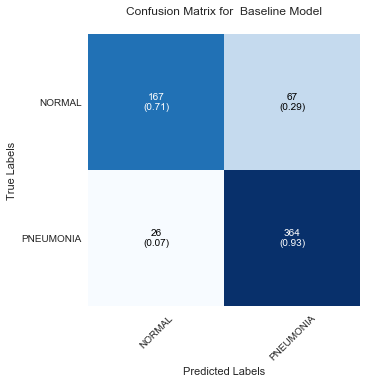

In [16]:
# Create Confusion Matrix
plt.style.use('seaborn')

cm = metrics.confusion_matrix(true_classes,predicted_classes)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5),
                                class_names = class_labels,
                                show_normed = True)
ax.set(title = "Confusion Matrix for  Baseline Model",
       ylabel = "True Labels",
       xlabel = "Predicted Labels")
plt.show()

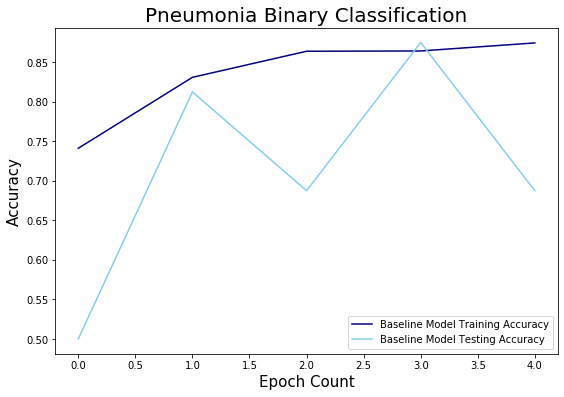

In [54]:
# Plot

train_loss = hist.history["accuracy"]
test_loss = hist.history["val_accuracy"]
plt.figure(figsize = (9,6))


plt.plot(train_loss, label = "Baseline Model Training Accuracy", color = "navy")
plt.plot(test_loss, label = "Baseline Model Testing Accuracy" , color= "skyblue")
plt.title("Pneumonia Binary Classification", fontsize = 20)
plt.xlabel("Epoch Count", fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend();

Correction: In the graph above, the light blue line is labelled as the Baseline Testing Accuracy but it is actually the validation accuracy. 

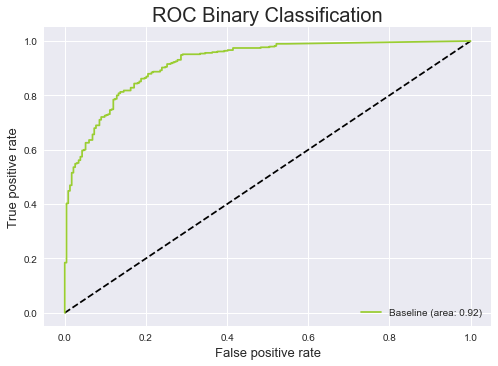

In [15]:
# ROC curve graph for baseline model
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(true_classes, pred)


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Baseline (area: %0.2f)'
             % auc(fpr,tpr), color= "yellowgreen")

plt.xlabel('False positive rate', fontsize = 13)
plt.ylabel('True positive rate', fontsize = 13)
plt.title('ROC Binary Classification', fontsize = 20)
plt.legend(loc='lower right')
plt.show()

In [55]:
# save weights from this model
model.save_weights("../output/custom_model.h5")